# Importing the needed Libraries & Directories

Importing the required libraries and directories are important to avoid errors for it also allows the codes to work perfectly.

In [25]:
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
import torch
from torch.nn import Sequential
from torch.nn import Conv2d, MaxPool2d, BatchNorm2d
from sklearn.model_selection import train_test_split
directory = "./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("./face-mask-detection-dataset/train.csv")
df_test = pd.read_csv("./face-mask-detection-dataset/submission.csv")

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
print(device)

cuda


# Importing SSD pretrained weights (Caffe Face Detector Model)

In [27]:
cvNet = cv2.dnn.readNetFromCaffe('./caffe-face-detector-opencv-pretrained-model/architecture.txt','./caffe-face-detector-opencv-pretrained-model/weights.caffemodel')

# Functions to be used

Retrieves Json

In [28]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

Adjusts gamma to make images more bright

In [29]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

# Pre-processing the Data

In [30]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '2310.png',
 'NumOfAnno': 3,
 'Annotations': [{'isProtected': False,
   'ID': 81768340414106304,
   'BoundingBox': [213, 169, 325, 299],
   'classname': 'face_other_covering',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 613664631614999424,
   'BoundingBox': [171, 168, 346, 299],
   'classname': 'hijab_niqab',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 166231871773593440,
   'BoundingBox': [435, 183, 470, 223],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

In [31]:

df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [32]:
print(df["classname"].unique())

['face_with_mask' 'mask_colorful' 'face_no_mask'
 'face_with_mask_incorrect' 'mask_surgical' 'face_other_covering'
 'scarf_bandana' 'eyeglasses' 'helmet' 'face_shield' 'sunglasses' 'hood'
 'hat' 'goggles' 'hair_net' 'hijab_niqab' 'other' 'gas_mask'
 'balaclava_ski_mask' 'turban']


In [33]:
len(df)

15409

In [34]:
def output_label(label):
    output_mapping = { 0:"face_with_mask", 1:"face_no_mask" , 2:"face_with_mask_incorrect"}
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

num_classes = 3

In [35]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels = { "face_with_mask":0, "face_no_mask":1 , "face_with_mask_incorrect":2 }

for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
            if(j['classname'] in labels):
                x,y,w,h = j["BoundingBox"]
                img = cv2.imread(os.path.join(image_directory,i),1)
                img = img[y:h,x:w]
                img = cv2.resize(img,(img_size,img_size))
                data.append([img,labels[j["classname"]]])
random.shuffle(data)  



In [36]:

print(len(data))

5898


<AxesSubplot:xlabel='count'>

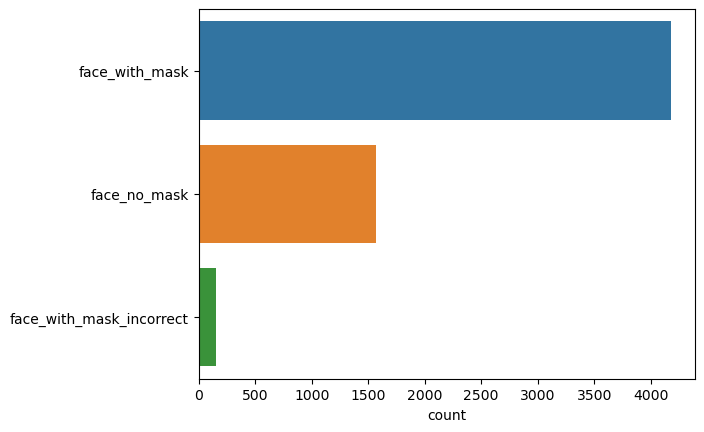

In [37]:
p = []
for face in data:
    p.append(output_label(face[1]))

sns.countplot(y=p)

The lines of code below is used for getting the shape of the features in the face mask data.

In [38]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

print(type(Y[0]))


<class 'int'>


In [39]:
X[0].shape

(124, 124, 3)

The lines of code below is used for getting the labels in the face mask data.

In [40]:
X = np.array(X)/255.0
Y = np.array(Y)

In [41]:
np.unique(Y)

array([0, 1, 2])

In [42]:
Y.shape

(5898,)

0
1
2


/home/saraiva/anaconda3/envs/daa/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  if sys.path[0] == "":


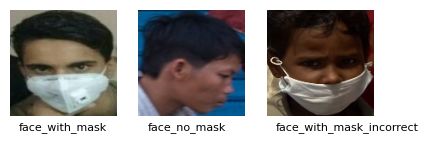

In [43]:
def get_imagem_label(features,labels,label):
    for i in range(len(labels)):
        if output_label(labels[i]) == output_label(label):
            return features[i]
    
def visualize_images(features,labels):
    plt.figure(figsize=(8,8))
    for i in range(num_classes):
        print(i)
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(b=None)
        imagem = get_imagem_label(features,labels,i)
        b,g,r = cv2.split(imagem)
        imagem_rgb = cv2.merge((r,g,b))
        
        plt.imshow(imagem_rgb)
        plt.text(10,140,output_label(i),fontsize=8)
    plt.show()


visualize_images(X,Y)

#  Model's Architecture

In [44]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.maxpool = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(460800, 50)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(50, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.float()
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = nn.ReLU()(self.conv3(x))
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.dropout2(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

model = Model()



print(model.conv1.weight.shape)
print(model.conv2.weight.shape)
print(model.conv3.weight.shape)
print(model.fc1.weight.shape)
print(model.fc2.weight.shape)




torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([50, 460800])
torch.Size([3, 50])


The line code below summarizes the model

In [45]:

model.to(device) 

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=460800, out_features=50, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=50, out_features=3, bias=True)
  (sigmoid): Sigmoid()
)

The line code below is for compiling the model by setting the loss to binary cross entropy, the optimizer to adam, and lastly, the metrics to accuracy.

In [46]:
import numpy as np

def get_probs(indexes, outputs):
    res = []
    for j in range(0,32):
        res.append(outputs[j][indexes[j]])
    print(res)
    return torch.tensor(res)

    

In [47]:
from livelossplot import PlotLosses


def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer,epochs):
    liveloss = PlotLosses()
    for epoch in range(epochs):
        logs = {}
        model.train() 
        running_loss  = 0.0
        running_corrects  = 0.0
        for batch_i, (inputs, labels) in enumerate(train_dl): 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) 
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
            
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) 
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()     
        liveloss.update(logs)
        liveloss.send()
    torch.save(model,h5_file)


Next, to get the xtrain, xval, ytrain, and yval, we have to use the train_test_split.

In [48]:

from sklearn.model_selection import train_test_split


xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)



tensor1 = torch.from_numpy(np.array(xtrain))
tensor2 =  torch.from_numpy(np.array(xtest))

tensor1 = tensor1.reshape(-1,3,124,124)
tensor2 = tensor2.reshape(-1,3,124,124)


train = torch.utils.data.TensorDataset( tensor1, torch.tensor(ytrain))
test = torch.utils.data.TensorDataset(tensor2, torch.tensor(ytest))


train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=32, shuffle=True)




In [49]:

def visualize_dataset(train_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Validação:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))
    print(f"Shape tensor batch casos validação, input: {x.shape}, output: {y.shape}")
    
    print(f'X: Valor maximo:{torch.max(x)} Valor mínimo:{torch.min(x)}')
    
    
    
visualize_dataset(train_dl)


Quantidade de casos de Treino:4128
Quantidade de casos de Validação:1770
Shape tensor batch casos treino, input: torch.Size([32, 3, 124, 124]), output: torch.Size([32])
Shape tensor batch casos validação, input: torch.Size([32, 3, 124, 124]), output: torch.Size([32])
X: Valor maximo:1.0 Valor mínimo:0.0


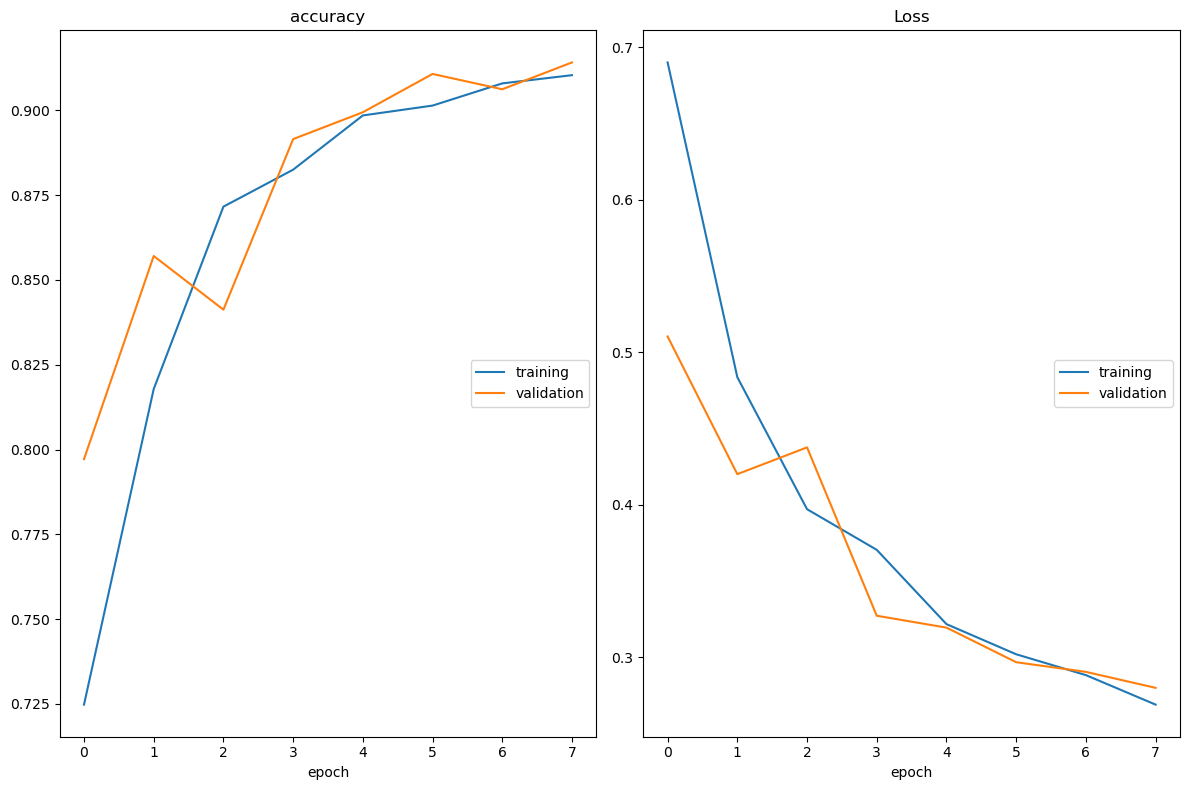

accuracy
	training         	 (min:    0.725, max:    0.910, cur:    0.910)
	validation       	 (min:    0.797, max:    0.914, cur:    0.914)
Loss
	training         	 (min:    0.269, max:    0.690, cur:    0.269)
	validation       	 (min:    0.280, max:    0.510, cur:    0.280)
Tempo gasto: 258.37319070600006 segundos


In [50]:
import time
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

EPOCHS = 8
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel.pth', train_dl, test_dl, model, criterion, optimizer,EPOCHS)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

# Testing unbonded images

In [51]:
test_images  = df_test['name'].unique()
labels = [ "face_with_mask", "face_no_mask" , "face_with_mask_incorrect" ]


print(len(test_images))

1698


### Filter test images

In [52]:

final_test_set = []

for i in range(100,111):
    final_test_set.append(test_images[i])


## Read Model

In [53]:
SAVED_MODEL = './CNNModel.pth'
model= torch.load(SAVED_MODEL)

[ WARN:0@849.533] global loadsave.cpp:244 findDecoder imread_('./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/2018.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'astype'

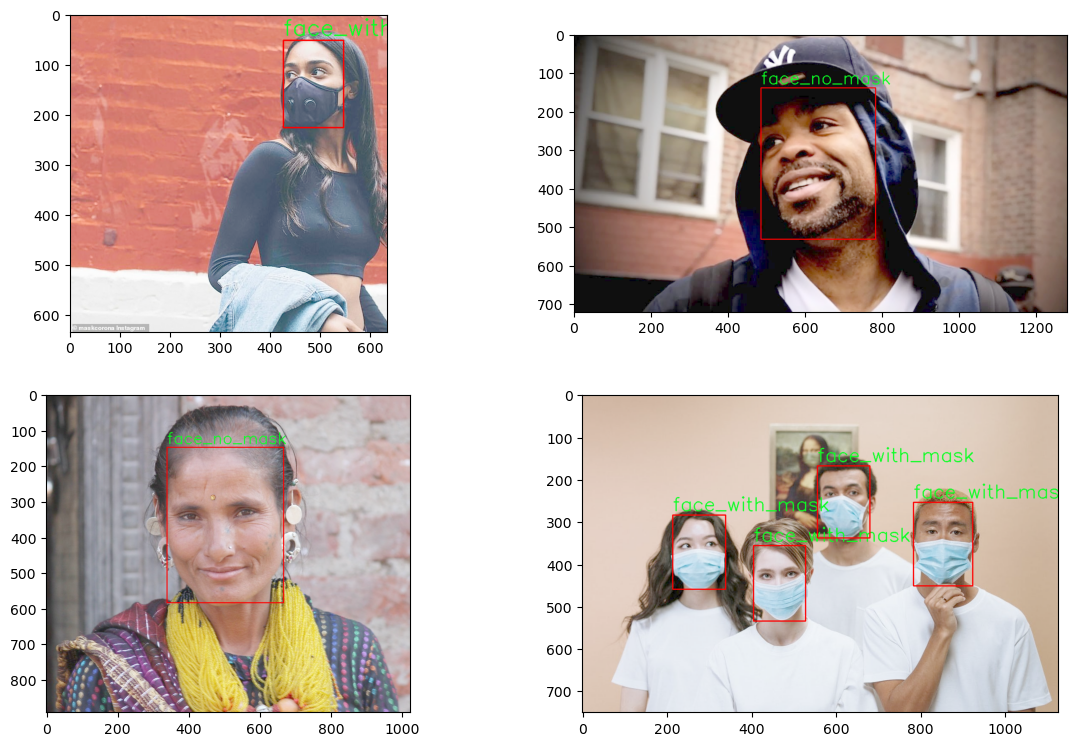

In [71]:

test_images = ['1114.png', '0001.jpg','0224.jpg', '0072.jpg','2018.jpg','0042.jpg']


def make_prediction(model, img): 
    img = torch.from_numpy(img)
    img = img.reshape(1, 3, 124, 124)
    img = img.to(device) #valves
    prediction = model(img).cpu().detach().numpy()[0].argmax()
    return prediction
    


gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {0:"face_with_mask", 1:"face_no_mask" , 2:"face_with_mask_incorrect"  , 3:"face_other_covering"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                result = make_prediction(model,im)
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[result] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except Exception as e:
            print(e)
          
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()